In [1]:
import pandas as pd
import numpy as np
import scipy.stats as st
import altair as alt
from scipy.stats import skewnorm
import seaborn as sns
import uuid

## Create fake data for senior BI case. 

In [ ]:
query = """
select user_id, 
	   case when tnc_country_group not in ('FRA','AUT','DEU','AUT','ITA') then 'Rest of Europe' else tnc_country_group end as market,
	   case when product_id like '%smart%' then 'New product' else 'Old product' end, 
	   sum(amount_cents_spaces::float/100) as spaces, 
	   sum(amount_cents_pt::float/100) as card_spend,
	   sum((amount_cents_ct+amount_cents_stripetopup_in)::float/100) as top_up
from dbt.zrh_txn_day 
inner join dbt.zrh_users using (user_created) 
where datediff('day', kyc_first_completed::date, txn_date::date) <= 35 
	and kyc_first_completed between '2020-12-01' and '2021-01-01'
	and is_fraudster = False 
	and closed_at is null
	and ft_mau is not null 
	and product_id not like '%BUSINESS%'
group by 1,2,3 
			
"""

In [2]:
import itertools

columns = ["spaces", "card_spend", "top_up"]
products = ["Old product", "New product"]
markets = ["FRA", "AUT", "DEU", "AUT", "ITA", "Rest of Europe"]

combinations = list(itertools.product(products, markets))

df = pd.read_csv("real_data.csv")
df["market"] = df["market"].str.strip()


def simulate_data(product, market):
    """
    Generate random data for that combination
    """
    data = pd.DataFrame()

    for col in ["spaces", "card_spend", "top_up"]:
        x = skewnorm.fit(
            np.array(df.loc[(df["case"] == product) & (df["market"] == market), col])
        )
        size = round(
            len(df.loc[(df["case"] == product) & (df["market"] == market), :]) * 0.5
        )

        data[col] = skewnorm(x[0], x[1], x[2]).rvs(size)
    data["market"] = market
    data["product"] = product
    return data


data = pd.DataFrame(columns=["market", "product", "top_up", "spaces", "card_spend"])

for com in combinations:
    data = data.append(simulate_data(com[0], com[1]))

data["user_id"] = [uuid.uuid4() for i in range(len(data))]

data.head()


data.to_csv("case_data.csv")

/Users/fabioschmidt-fischbach/anaconda3/lib/python3.7/site-packages/scipy/stats/_distn_infrastructure.py:1682: RuntimeWarning: divide by zero encountered in log
  return log(self._pdf(x, *args))


In [58]:
print(data.shape)

(26007, 6)


## Check that data looks sensible. 

In [67]:
x = data.groupby(["market", "product"]).count().reset_index()

x["perc"] = 100 * x["top_up"] / x.groupby(["market"])["top_up"].transform("sum")

x.loc[x["product"] == "New product", :]

,market,product,top_up,spaces,card_spend,user_id,perc
0,AUT,New product,60,60,60,60,4.497751
2,DEU,New product,297,297,297,297,4.981550
4,FRA,New product,476,476,476,476,7.184906
6,ITA,New product,110,110,110,110,1.986994
8,Rest of Europe,New product,258,258,258,258,3.938931


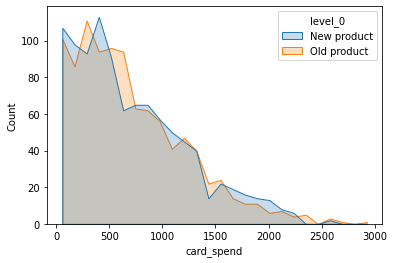

In [6]:
sns.histplot(data=data, x="card_spend", hue="level_0", element="poly")

In [9]:
data.card_spend.mean()

701.7256224900168

In [10]:
data.top_up.mean()

6385.46715868724

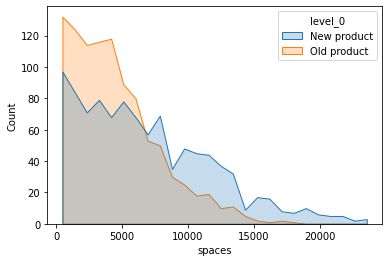

In [7]:
sns.histplot(data=data, x="spaces", hue="level_0", element="poly")

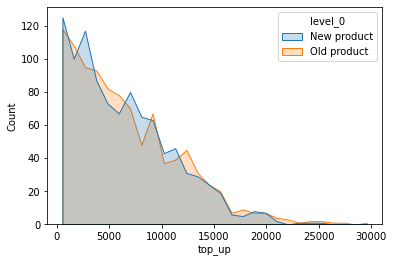

In [8]:
sns.histplot(data=data, x="top_up", hue="level_0", element="poly")